<b><h2 style="text-align:center;">COMM493 - Coding AI for Business</h2><b>

<h5 style="text-align:center;">Assignment 1 - Linear Learner Data Identification & Preparation</h5>

<h5 style="text-align:center;">Maxwell Brookes - 20244724</h5>

<h5 style="text-align:center;">Due on Feb 9</h5>


<b><h4>0: Intro</h4><b>
<h5>About The Dataset: asdjklasj klasjkl fjaklsdjfklsjadklf jalskfjklsd j fasdklj fklasjdf ljaslfjsdlfj kadj</h5>
<h5>Goal: asdjklasj klasjkl fjaklsdjfklsjadklf jalskfjklsd j fasdklj fklasjdf ljaslfjsdlfj kadj</h5>


<b><h4>1: Load Modules & Tools:</h4><b>

In [1]:
import numpy as np  # for linear algebra
import pandas as pd  # for loading data
import seaborn as sns  # for heatmap
import matplotlib.pyplot as plt  # for visualizations
import sys  # for system information
from sklearn.model_selection import train_test_split  # for splitting dataset
from sklearn.feature_selection import VarianceThreshold # for cleaning data
from sklearn.preprocessing import StandardScaler  # for normalizing data

print(sys.version)
print("Successfully Loaded All Modules")

3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
Successfully Loaded All Modules



<b><h4>2: Load Dataset:</h4><b>

In [2]:
# dataset = https://www.kaggle.com/datasets/smac91/hotel-bookings, implementation = https://www.kaggle.com/datasets/somnathnaskar/hotel-booking-dataset/data
df = pd.read_csv('hotel_bookings.csv')  # Load the CSV file into a DataFrame
target_column = 'is_canceled'  # define target column (what I want to predict)


<b><h4>3: Preview Dataset:</h4><b>

In [3]:
print('Data Shape:', df.shape)  # print the shape of the data
print('Data Preview:')
print(df.iloc[:10, :5].to_string(index=False))  # list first 10 row and columns

Data Shape: (119390, 32)
Data Preview:
       hotel  is_canceled  lead_time  arrival_date_year arrival_date_month
Resort Hotel            0        342               2015               July
Resort Hotel            0        737               2015               July
Resort Hotel            0          7               2015               July
Resort Hotel            0         13               2015               July
Resort Hotel            0         14               2015               July
Resort Hotel            0         14               2015               July
Resort Hotel            0          0               2015               July
Resort Hotel            0          9               2015               July
Resort Hotel            1         85               2015               July
Resort Hotel            1         75               2015               July



<b><h4>4: Drop Columns:</h4><b>
<h5>'agent' and 'company' because it doe snot matter in this context</h5>
<h5>'arrival_date_week_number' because 'arrival_date_month' and 'arrival_date_day_of_month' are already included</h5>
<h5>'country' because analysis is not based on location</h5>
<h5>'distribution_channel' because it has overlap with 'market_segment'</h5>
<h5>'days_in_waiting_list' because most values are zero</h5>
<h5>'meal' because most values are BB, which implies that all hotels offer the same</h5>
<h5>'reservation_status_date' because the info is already captured with 'lead_time'</h5>
<h5>'reservation_status' conveys the same information as 'is_cancelled'</h5>
<h5>'reserved_room_type' and 'assigned_room_type' because a small kingston business will not have many room options</h5>h5

In [4]:
# print(df.columns)  # Check available columns
# unique_dict = {col: df[col].unique() for col in df.columns}
# for col, uniques in unique_dict.items():
#     print(f"{col}: {uniques}")

columns_to_drop = ['agent', 'company', 'arrival_date_week_number', 'country', 'distribution_channel', 'days_in_waiting_list', 'meal', 'reservation_status', 'reservation_status_date', 'arrival_date_year', 'arrival_date_day_of_month', 'reserved_room_type', 'assigned_room_type'] # maybe add is_repeated_guest 
df.drop(columns_to_drop, axis=1, inplace=True)  # drop columns without having to create a new pandas data frame

# only use City Hotels
df.drop(df[df['hotel'] == 'Resort Hotel'].index, inplace=True)  # Drop all rows where 'hotel' is 'Resort Hotel'
df.drop(['hotel'], axis=1, inplace=True)  # Drop the 'hotel' column since only 'City Hotel' remains

df.drop_duplicates(keep='first', inplace=True)  # Drop duplicate rows, keeping only the first occurrence

print('Data Shape:', df.shape)

Data Shape: (50680, 18)



<b><h4>5: Encode Categorial Features</h4><b>

In [5]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    if df[col].nunique() > 6:  # Frequency Encoding
        freq_encoding = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq_encoding)
    else:  # One-Hot Encoding
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df.drop(columns=[col], inplace=True)
        for dummy_col in dummies.columns:
            df[dummy_col] = dummies[dummy_col]
assert len(df.select_dtypes(include=[np.number]).columns) == len(df.columns), "Data contains non-numeric columns."


<b><h4>6: Further Cleaning (Rows, Unrealistic, Outliers, ...):</h4><b>

In [6]:
df['children'].fillna(0, inplace=True)  # Replace NaN values in 'children' with 0

# remove low variance features
selector = VarianceThreshold(threshold=0.01)
df_reduced = selector.fit_transform(df)
selected_features = df.columns[selector.get_support(indices=True)]
df = pd.DataFrame(df_reduced, columns=selected_features)

# remove outliers, value > mean + 3*standard deviation
for col in df.columns:
    upper_limit = df[col].quantile(0.99)
    lower_limit = df[col].quantile(0.01)
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])

assert (df.isnull().values.any() == False), 'Data contains null values.'  # make sure that there are no null values

df.reset_index(drop=True, inplace=True)  # Reset the indicies after all modifications

print('Data Shape:', df.shape)  # print the shape of the data
print('Data Preview:')
print(df.iloc[:10, :5].to_string(index=False))  # list first 10 row and columns

Data Shape: (50680, 18)
Data Preview:
 is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  adults
         0.0        6.0                      0.0                   2.0     1.0
         1.0       88.0                      0.0                   4.0     2.0
         1.0       65.0                      0.0                   4.0     1.0
         1.0       92.0                      2.0                   4.0     2.0
         1.0      100.0                      0.0                   2.0     2.0
         1.0       79.0                      0.0                   3.0     2.0
         0.0        3.0                      0.0                   3.0     1.0
         1.0       63.0                      1.0                   3.0     1.0
         1.0       62.0                      2.0                   3.0     2.0
         0.0       43.0                      0.0                   2.0     2.0



<b><h4>7: Correlation Analysis:</h4><b>
<h5>Unfortuantely no valriables have a strong correlations with 'is_canceled'</h5>
<h5>Target business will have to collect more data as a part of this venture</h5>

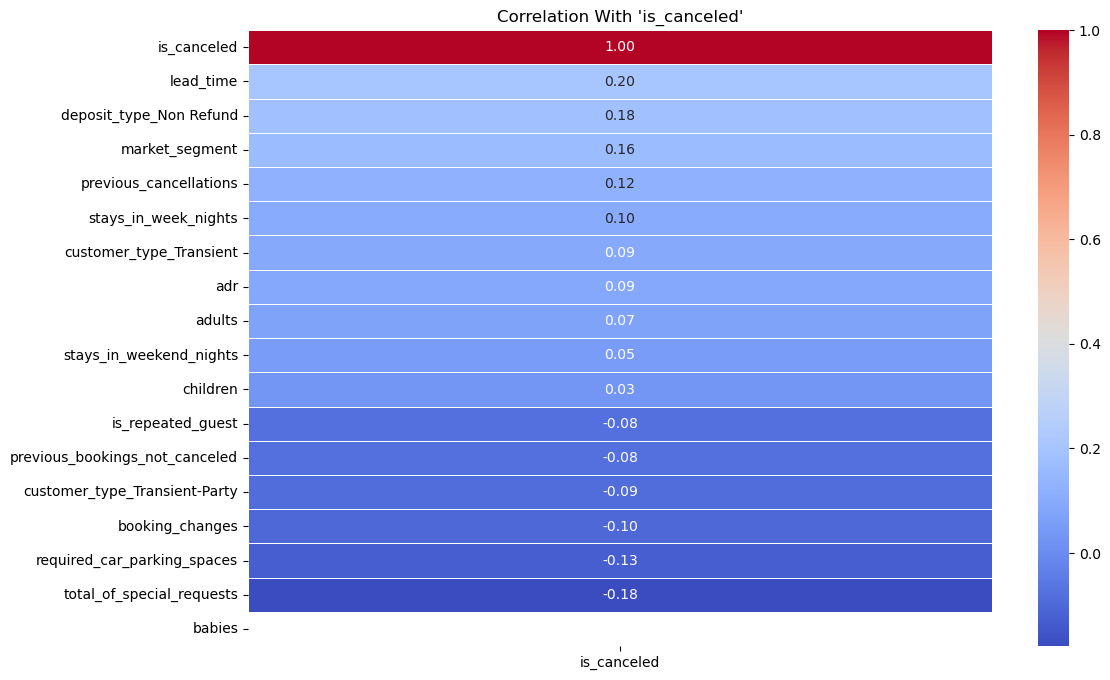

In [7]:
# print('Correlations With \'is_canceled\'')
corr_values = df.corr(numeric_only=True)[target_column].sort_values(ascending=False)
# print(corr_values)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_values.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation With \'is_canceled\'')
plt.show()
plt.close()


<b><h4>8: Split Data For Training and Evaluation:</h4><b>

In [8]:
x = df.drop(columns=[target_column])  # Features (independent variables)
y = df[target_column]  # Target variable (what we want to predict)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.2, random_state=42)  # 80/20 split, random_state is fixed for reproducibility 

print(x_train.shape, x_eval.shape, y_train.shape, y_eval.shape)

(40544, 17) (10136, 17) (40544,) (10136,)



<b><h4>9: Perform Linear Data Analysis Using SageMakerAI</h4><b>